In [6]:
#OBJECTIVE:Predict if a passenger survived or not in the sinking of Titanic 
#METRIC: % of accuracy 
#SUBMISSION: csv with 2 columns (passenger ID and predicted class)

In [102]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [64]:
df = pd.read_csv("train.csv")
df.drop(['Name'], 1, inplace=True)
df.convert_objects(convert_numeric=True)
df.fillna(0, inplace=True)
print(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB
None    PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
0            1         0       3    male  22.0      1      0   
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   

             Ticket     Fare Cabin Embarked  
0         A/5 

/Users/derrinechia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
#method 1: convert to numeric for gender variable 
def sex_to_numeric(x):
    if x=='male':
        return 1
    if x=='female':
        return 2
df['Sex'] = df['Sex'].apply(sex_to_numeric)

In [66]:
def embarked_to_numeric(y):
    if y=="S":
        return 1
    if y=='C':
        return 2
    if y=='Q':
        return 3
    
df['Embarked'] = df['Embarked'].apply(embarked_to_numeric)

In [67]:
#method 2: convert to numeric using label encoder (but not applicable for str/int instances e.g. cabin and embarked )
label = LabelEncoder()
df['Ticket'] = label.fit_transform(df['Ticket'])

In [76]:
#method 3: convert into numeric 
def non_numeric_data(df):
    columns = df.columns.values
    for column in columns:
        numeric_data = {}
        
        def transform_to_numeric(x):
            return numeric_data[x]
        
        if df[column].dtype != np.int64 and df[column].dtype != np.float64: 
            col_contents = df[column].values.tolist()
            col_elements = set(col_contents)
            i = 0
            for element in col_elements: 
                if element not in numeric_data:
                    numeric_data[element] = i
                    i += 1
            df[column] = list(map(transform_to_numeric, df[column])) 
    return df                   

In [77]:
df = non_numeric_data(df)

In [79]:
#double check - all converted to int or float
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null int64
Fare           891 non-null float64
Cabin          891 non-null int64
Embarked       889 non-null float64
dtypes: float64(3), int64(8)
memory usage: 76.6 KB


(None,
    PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch  Ticket     Fare  \
 0            1         0       3    1  22.0      1      0     523   7.2500   
 1            2         1       1    2  38.0      1      0     596  71.2833   
 2            3         1       3    2  26.0      0      0     669   7.9250   
 3            4         1       1    2  35.0      1      0      49  53.1000   
 4            5         0       3    1  35.0      0      0     472   8.0500   
 
    Cabin  Embarked  
 0      0       1.0  
 1     57       2.0  
 2      0       1.0  
 3     11       1.0  
 4      0       1.0  )

In [80]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,889.000000
mean,446.000000,0.383838,2.308642,1.352413,23.799293,0.523008,0.381594,338.528620,32.204208,16.263749,1.362205
std,257.353842,0.486592,0.836071,0.477990,17.596074,1.102743,0.806057,200.850657,49.693429,36.152471,0.636157
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,1.000000,6.000000,0.000000,0.000000,158.500000,7.910400,0.000000,1.000000
50%,446.000000,0.000000,3.000000,1.000000,24.000000,0.000000,0.000000,337.000000,14.454200,0.000000,1.000000
75%,668.500000,1.000000,3.000000,2.000000,35.000000,1.000000,0.000000,519.500000,31.000000,0.000000,2.000000
max,891.000000,1.000000,3.000000,2.000000,80.000000,8.000000,6.000000,680.000000,512.329200,147.000000,3.000000


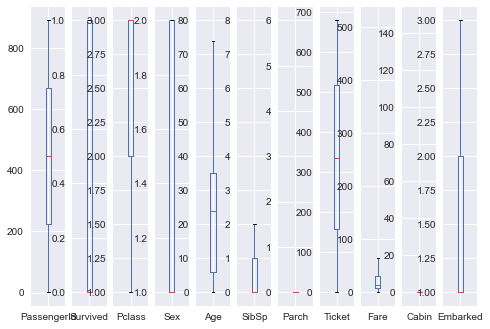

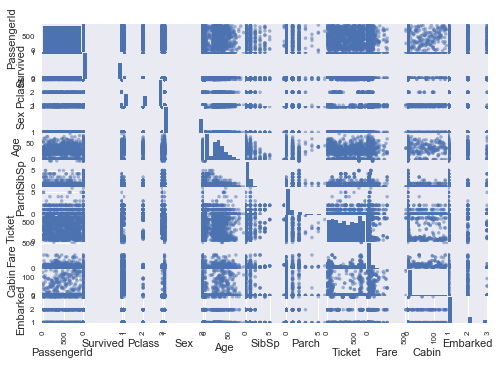

In [81]:
#data visualization 
df.plot(kind='box', subplots=True, sharex=False, sharey=False)
scatter_matrix(df)
plt.show()

In [84]:
#missing values in Embarked
df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked        True
dtype: bool

In [85]:
#replace all NAN elements with 0
df.fillna(0, inplace=True)

In [160]:
X = np.array(df.drop(['Survived', 'PassengerId'],1).astype(float))
Y = np.array(df['Survived'])

In [93]:
#Perform feature selections using RFE - select top 5 features
model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X,Y)
print(fit.n_features_)
print(np.asarray(df.columns.drop(['Survived', 'PassengerId'])))
print(rfe.ranking_)
print(rfe.support_)

5
['Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare' 'Cabin' 'Embarked']
[1 1 1 1 2 5 4 3 1]
[ True  True  True  True False False False False  True]


In [94]:
#automatically select best number of features after cross-validation using RFECV
rfecv = RFECV(estimator=model, step=1, cv=10)
fit = rfecv.fit(X,Y)
print(fit.n_features_)
print(np.asarray(df.columns.drop(['Survived', 'PassengerId'])))
print(rfecv.ranking_)
print(rfecv.support_)

9
['Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare' 'Cabin' 'Embarked']
[1 1 1 1 1 1 1 1 1]
[ True  True  True  True  True  True  True  True  True]


In [105]:
#conduct logistic regression with all features
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

model = LogisticRegression()
logreg = model.fit(X_train, Y_train)
predictions = model.predict(X_test)
print('accuracy score', accuracy_score(Y_test, predictions))

accuracy score 0.798882681564


In [96]:
#conduct logistic regression with selected features
X2 = np.array(df.drop(['Survived', 'PassengerId', 'Age', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],1).astype(float))
X2_train, X2_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.20, random_state=1)

model = LogisticRegression()
logreg = model.fit(X2_train, Y_train)
predictions = model.predict(X2_test)
print('accuracy score', accuracy_score(Y_test, predictions))

accuracy score 0.77094972067


In [ ]:
#result shows using all features has better accuracy score than using top 5 features

In [103]:
#KNN
knn = KMeans(n_clusters=2)
knn.fit(X_train, Y_train)

correct = 0 
for i in range(len(X)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = clf.predict(predict_me)
    if prediction[0] == Y[i]:
        correct += 1 

print(correct/len(X))

0.569023569023569


In [106]:
#Decision Trees 
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, Y_train)
predictions = model.predict(X_test)
print('accuracy scre', accuracy_score(Y_test, predictions))

accuracy scre 0.798882681564


In [109]:
#Random Forest
random_forest_model = RandomForestClassifier(verbose=1)
random_forest_model.fit(X_train, Y_train)
predictions = model.predict(X_test)
print('accuracy_score', accuracy_score(Y_test, predictions))

accuracy_score 0.798882681564


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [150]:
test_df = pd.read_csv('test.csv')

In [151]:
test_df.info(), test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


(None,
    PassengerId  Pclass                                          Name     Sex  \
 0          892       3                              Kelly, Mr. James    male   
 1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
 2          894       2                     Myles, Mr. Thomas Francis    male   
 3          895       3                              Wirz, Mr. Albert    male   
 4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
 
     Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
 0  34.5      0      0   330911   7.8292   NaN        Q  
 1  47.0      1      0   363272   7.0000   NaN        S  
 2  62.0      0      0   240276   9.6875   NaN        Q  
 3  27.0      0      0   315154   8.6625   NaN        S  
 4  22.0      1      1  3101298  12.2875   NaN        S  )

In [152]:
test_df = non_numeric_data(test_df)

In [ ]:
test_df.fillna(0, inplace=True)

In [162]:
df['label'] = 'train'
test_df['label'] = 'test'

In [163]:
concat_data = pd.concat([df , test_df])

In [165]:
# Split your data
train_df = concat_data[concat_data['label'] == 'train']
test_df = concat_data[concat_data['label'] == 'test']

In [173]:
train_df.isnull().any(), test_df.isnull().any()

(Age            False
 Cabin          False
 Embarked       False
 Fare           False
 Name            True
 Parch          False
 PassengerId    False
 Pclass         False
 Sex            False
 SibSp          False
 Survived       False
 Ticket         False
 label          False
 dtype: bool, Age            False
 Cabin          False
 Embarked       False
 Fare           False
 Name           False
 Parch          False
 PassengerId    False
 Pclass         False
 Sex            False
 SibSp          False
 Survived        True
 Ticket         False
 label          False
 dtype: bool)

In [174]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

/Users/derrinechia/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [177]:
train_df = non_numeric_data(train_df)
test_df = non_numeric_data(test_df)

/Users/derrinechia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [178]:
x_train = np.array(train_df.drop(['Survived','PassengerId', 'label', 'Name'],1).astype(float)) 
y_train = np.array(train_df['Survived'])

In [179]:
x_test = np.array(test_df.drop(['Survived','PassengerId', 'label', 'Name'],1).astype(float))
y_test = np.array(test_df['Survived'])

In [184]:
#Random Forest
model = RandomForestClassifier(verbose=1)
model.fit(x_train, y_train)
y_test = model.predict(x_test) #testing

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [185]:
y_test[:5]

array([ 0.,  0.,  0.,  0.,  1.])

In [189]:
test_df['Survived'].value_counts()

0.0    353
1.0     65
Name: Survived, dtype: int64

In [190]:
test_df.to_csv('Testing Data Submission')

In [204]:
data = pd.read_csv("Testing Data Submission", index_col=0)

In [205]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,label
0,34.5,0,0.0,7.8292,350.0,0,892,3,1,0,0.0,77,0
1,47.0,0,2.0,7.0000,243.0,0,893,3,0,1,0.0,45,0
2,62.0,0,0.0,9.6875,356.0,0,894,2,1,0,0.0,284,0
3,27.0,0,2.0,8.6625,0.0,0,895,3,1,0,0.0,198,0
4,22.0,0,2.0,12.2875,301.0,1,896,3,0,1,1.0,40,0


In [206]:
data.drop(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'label'], 1, inplace=True)

In [208]:
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null float64
dtypes: float64(1), int64(1)
memory usage: 9.8 KB


(   PassengerId  Survived
 0          892       0.0
 1          893       0.0
 2          894       0.0
 3          895       0.0
 4          896       1.0, None)

In [212]:
data.to_csv("Final Submission", index=False)